Going to actually simulate how deep we can go when azimuthal averaging.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u
%matplotlib inline

Make a mock data set (can be just zeros in the array) with the 2.8" size pixels. (do it with 6.4 " first to make sure consistent with other script -- worked: with res = 6.4", data size was (64,64), the same as from the galaxy cutout script)

In [102]:
resolution = 2.8

pixscale = {'50Mpc': 0.237/1000.*(1.+0.0115),'100Mpc': 0.477/1000.*(1.+0.0235),\
            '200Mpc': 0.928/1000.*(1.+0.047),'500Mpc': 2.178/1000.*(1.+0.12),\
            '980Mpc': 3.825/1000.*(1.+0.24)} ### Mpc / arcsec (comoving)

kpcperpix_100 = pixscale['100Mpc'] * resolution * 1000. # at 100 Mpc from us
kpcperpix_50  = pixscale['50Mpc'] * resolution * 1000. # at 50 Mpc from us

print kpcperpix_50*3
print kpcperpix_100

# Let's make the data the same size as the galaxy cutout boxes e.g. 200 kpc across
data_pretend_50 = np.zeros((200./kpcperpix_50, 200./kpcperpix_50))
print data_pretend_50.shape

# Let's make the data the same size as the galaxy cutout boxes e.g. 200 kpc across
data_pretend_100 = np.zeros((200./kpcperpix_100, 200./kpcperpix_100))
print data_pretend_100.shape


print 'The angular size of the pretend data at 50 Mpc is: %s'%(.200/pixscale['50Mpc'])
print 'The angular size of the pretend data at 100Mpc is: %s'%(.200/pixscale['100Mpc'])


2.0136942
1.3669866
(297, 297)
(146, 146)
The angular size of the pretend data at 50 Mpc is: 834.287549718
The angular size of the pretend data at 100Mpc is: 409.660197108


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


Use the radial profile script to determine how many bins are being added up at each radius.

In [67]:
def radial_profile(data, center, debug=False):
    data = 10**data
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())  ## radial profile before dividing by num of data points
    nr = np.bincount(r.ravel())                  ## num of data points
    radialprofile = tbin / nr
    if debug:
        return r,tbin,nr,np.log10(radialprofile)
    else:
        return np.log10(radialprofile )


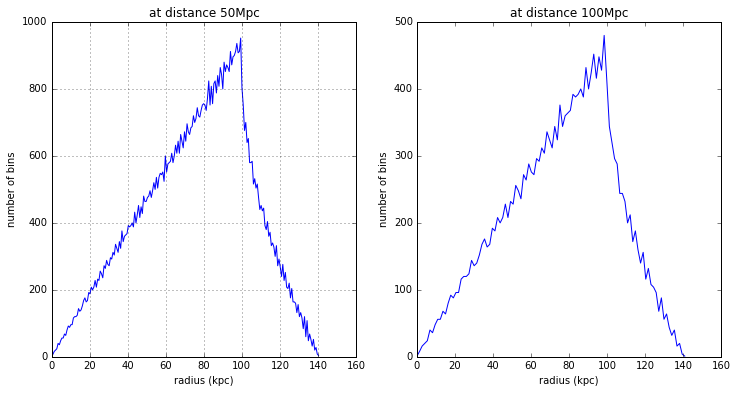

In [103]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12, 6))

center, radi = (data_pretend_50.shape[0]/2,data_pretend_50.shape[1]/2), 55
r_50,tbin,nr,rad = radial_profile(data_pretend_50, center, debug=True)
ax1.plot(np.arange(len(nr))*kpcperpix_50,nr)

center, radi = (data_pretend_100.shape[0]/2,data_pretend_100.shape[1]/2), 55
r_100,tbin,nr,rad = radial_profile(data_pretend_100, center, debug=True)
ax2.plot(np.arange(len(nr))*kpcperpix_100,nr)
ax1.grid()
ax1.set_title('at distance 50Mpc')
ax2.set_title('at distance 100Mpc')

ax1.set_xlabel('radius (kpc)')
ax2.set_xlabel('radius (kpc)')
ax1.set_ylabel('number of bins')
ax2.set_ylabel('number of bins')


In [69]:
#np.savetxt('radiusmap_100.txt',r_100,fmt='%s',)

In [70]:
#print r_100

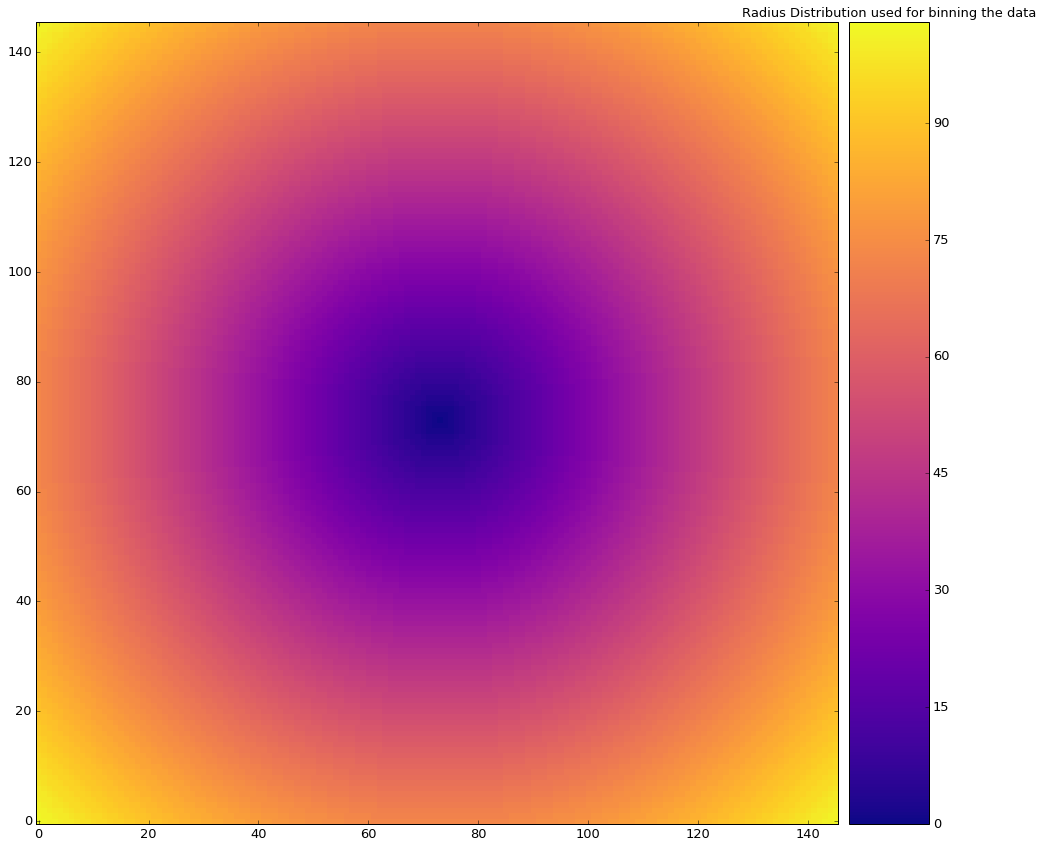

In [226]:
def plotdata(data,ax=None,bounds=None,colorbar=False,colmap='viridis',extent=None,aspect=None):
    """
    General use plotting of image
    """
    if ax is None:
        fig = plt.figure(figsize=(6, 3.2))
        ax = fig.add_subplot(111)
        oneplot=True
    if bounds is None and extent is None:
        img = ax.imshow(data,origin='lower',cmap=cm.get_cmap(colmap),interpolation='nearest')
    elif extent is None:
        img = ax.imshow(data,origin='lower',cmap=cm.get_cmap(colmap),vmin=bounds[0],vmax=bounds[1],interpolation='nearest')
    else:
        img = ax.imshow(data,origin='lower',cmap=cm.get_cmap(colmap),vmin=bounds[0],vmax=bounds[1],\
                        interpolation='nearest', extent=extent,aspect=aspect)
    ax.set_aspect('equal')
    
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    ax.patch.set_facecolor('black')
    
    if colorbar:
        div = axgrid.make_axes_locatable(ax)
        cax = div.append_axes("right",size="10%",pad=0.15)
        cbar = plt.colorbar(img,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
        cbar.ax.tick_params()
        
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
plotdata(r_100,ax=ax,colorbar=True,colmap='plasma')
plt.title('Radius Distribution used for binning the data')

In [86]:
def Dragonfly(CMOS=True,filtwidth=3.0,verbose=True,R=None,old=False):
    area_lens = np.pi*(14.3/2)**2 * 48. * u.cm**2               # 48 * 14.3 cm diameter lenses
    pix_size = 2.8                                              # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2 * u.rad**2   # rad^2, the pixel size of the CCD

    tau_l = 0.85  # transmittance of the Dragonfly lens
    tau_f = 1.    # transmittance of the Halpha filter -- assumed for now
    if CMOS:
        print "VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)"
        QE = 0.70                                           # quantum efficiency of the CMOS detector
    else:
        print "VERBOSE: Using old cameras... (QE = 0.48, R = 10.)"
        QE = 0.48                                           # quantum efficiency of the CCD

    # The following are per pixel
    D = 0.04 *u.photon/u.second                             # dark current (electrons / s) -- PER PIXEL??
    R_squared = 10.**2 * u.photon                           # read noise (electrons)
    
    #filtdict = {1.0:0.560633,3.0:1.473626,'SloanG':60.0}
    if old:
        B = 0.52135 *u.photon/u.second/u.nm/u.arcsec**2/u.m**2  # sky background at 565.6 nm 
    else:
        B = 1.473626 *u.photon/u.second/u.arcsec**2/u.m**2  # sky background at 565.6 nm in 3 nm filter
    #B = filtdict[filtwidth]
    
    if R is None:
        if CMOS:
            R = 2.                                          # read noise of CMOS (electrons)
        else:
            R = 10.                                         # read noise of CCD (electrons)
    
    R_squared = R**2 * u.photon
    
    if verbose:
        print ""
        print "[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared]"
        print [area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared]
        print ""
    
    return [area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared]



In [94]:
old=False

[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared] = Dragonfly(CMOS=True,old=old)

print([area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared])
wavelen = 656.3e-9 * u.m

### SB of extended halos
SB_ph_upper = 2245.38 * u.photon / (u.cm**2 * u.rad**2 * u.second) # threshold from Steidel et al 2011 plus long translations
SB_ph_lower = 559.60 * u.photon / (u.cm**2 * u.rad**2 * u.second)  # from van de Voort & Schaye 2013 (high mass out to 100 kpc)
SB_ph_evenlower = 280. * u.photon / (u.cm**2 * u.rad**2 * u.second)  # from van de Voort & Schaye 2013 (medium mass out to 50 kpc)
SB_ph_abslowest = 140. * u.photon / (u.cm**2 * u.rad**2 * u.second)  # from van de Voort & Schaye 2013 (medium mass out to 80 kpc)

SB_ph_0 = 1. * u.photon / (u.cm**2 * u.rad**2 * u.second) 
SB_ph_1 = 10. * u.photon / (u.cm**2 * u.rad**2 * u.second) 
SB_ph_2 = 100. * u.photon / (u.cm**2 * u.rad**2 * u.second) 
SB_ph_3 = 1000. * u.photon / (u.cm**2 * u.rad**2 * u.second) 
SB_ph_4 = 10000. * u.photon / (u.cm**2 * u.rad**2 * u.second) 

SB_ph_5 = 250. * u.photon / (u.cm**2 * u.rad**2 * u.second) 
SB_ph_6 = 500. * u.photon / (u.cm**2 * u.rad**2 * u.second) 
SB_ph_7 = 750. * u.photon / (u.cm**2 * u.rad**2 * u.second) 

print('Surface brightness: '+str(SB_ph_evenlower))

VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)

[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared]
[<Quantity 7709.091380790922 cm2>, <Quantity 1.8427438923353984e-10 rad2>, 2.8, 0.85, 1.0, 0.7, <Quantity 1.473626 ph / (arcsec2 m2 s)>, <Quantity 0.04 ph / s>, <Quantity 4.0 ph>]

[<Quantity 7709.091380790922 cm2>, <Quantity 1.8427438923353984e-10 rad2>, 2.8, 0.85, 1.0, 0.7, <Quantity 1.473626 ph / (arcsec2 m2 s)>, <Quantity 0.04 ph / s>, <Quantity 4.0 ph>]
Surface brightness: 280.0 ph / (cm2 rad2 s)


Halpha Signal: 8.45249922916e-07 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 8.45249922916e-06 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 8.45249922916e-05 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.000845249922916 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.00845249922916 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.000211312480729 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.000422624961458 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.000633937442187 ph / s
Background Sky: 5.29935094932 ph / s


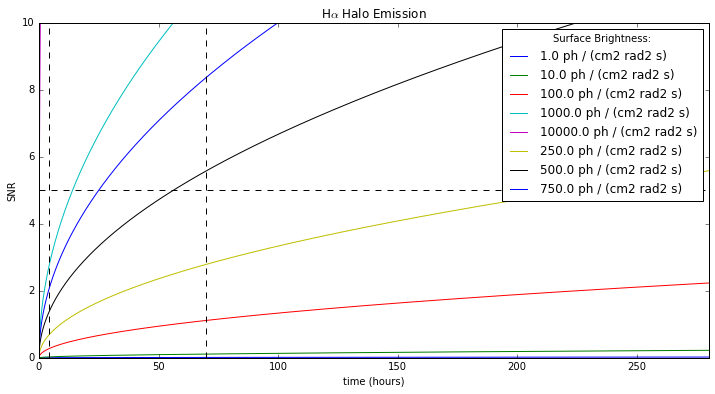

In [98]:
# pick numpixels:
numpixel = 3700.

# pick how long to calculate SNR over
time = np.arange(1,60.*60.*1000000.,1000)* u.second
time = np.arange(1,60.*60.*280.)* u.second
limit = time[-1]/u.second

fig,(ax1) = plt.subplots(1,1,figsize=(12, 6))

for SB_ph in [SB_ph_0, SB_ph_1, SB_ph_2, SB_ph_3, SB_ph_4,SB_ph_5,SB_ph_6,SB_ph_7]:
#for SB_ph in [SB_ph_upper, SB_ph_lower, SB_ph_evenlower, SB_ph_abslowest]:
    ## Signal
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    signal = S*time*numpixel
    ## Noise
    if old:
        B_tot = B * QE * tau_l * tau_f * 3.*u.nm * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    else:
        B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

    # Note that the signal is about an eighth the strength of the background sky signal: IS THIS TRUE HERE?
    print('Halpha Signal: '+str(S))
    print('Background Sky: ' +str(B_tot))

    ax1.plot(time/3600., signal/sigma, label=str(SB_ph))#,label= 'num pixels '+str(round(numpixel)))

ax1.plot([0,limit/3600.],[5,5],'k--')   
plt.title(r'H$\alpha$ Halo Emission')
ax1.legend(title='Surface Brightness:')
ax1.set_xlim(0,limit/3600.)
ax1.set_ylim(0,10)
ax1.set_xlabel('time (hours)')
ax1.set_ylabel('SNR')

ax1.plot([4.,4.],[0,10],'k--')  # ~4 hour ~250min
ax1.plot([70,70],[0,10],'k--')  # ~70 hour ~4200min


#plt.savefig('HalphaHaloEmission.pdf')


Halpha Signal: 8.45249922916e-05 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.000211312480729 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.000422624961458 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.000633937442187 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.000845249922916 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.00845249922916 ph / s
Background Sky: 5.29935094932 ph / s


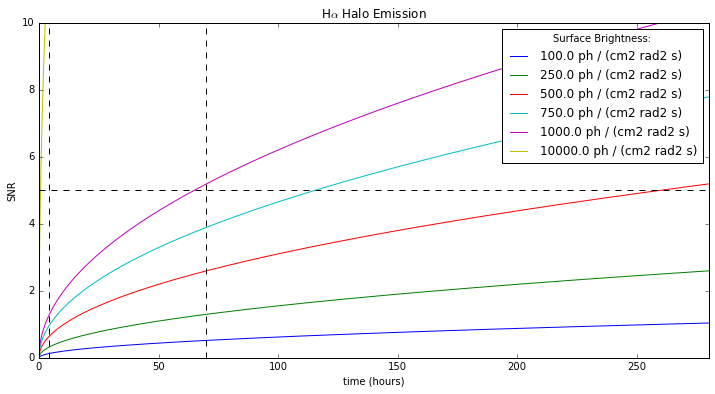

In [104]:
# pick numpixels:
numpixel = 800.

# pick how long to calculate SNR over
time = np.arange(1,60.*60.*280.)* u.second
limit = time[-1]/u.second

fig,(ax1) = plt.subplots(1,1,figsize=(12, 6))

for SB_ph in [SB_ph_2, SB_ph_5,SB_ph_6,SB_ph_7, SB_ph_3, SB_ph_4]:
#for SB_ph in [SB_ph_upper, SB_ph_lower, SB_ph_evenlower, SB_ph_abslowest]:
    ## Signal
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    signal = S*time*numpixel
    ## Noise
    if old:
        B_tot = B * QE * tau_l * tau_f * 3.*u.nm * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    else:
        B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

    # Note that the signal is about an eighth the strength of the background sky signal: IS THIS TRUE HERE?
    print('Halpha Signal: '+str(S))
    print('Background Sky: ' +str(B_tot))

    ax1.plot(time/3600., signal/sigma, label=str(SB_ph))#,label= 'num pixels '+str(round(numpixel)))

ax1.plot([0,limit/3600.],[5,5],'k--')   
plt.title(r'H$\alpha$ Halo Emission')
ax1.legend(title='Surface Brightness:')
ax1.set_xlim(0,limit/3600.)
ax1.set_ylim(0,10)
ax1.set_xlabel('time (hours)')
ax1.set_ylabel('SNR')

ax1.plot([4.,4.],[0,10],'k--')  # ~4 hour ~250min
ax1.plot([70,70],[0,10],'k--')  # ~70 hour ~4200min


#plt.savefig('HalphaHaloEmission.pdf')


In [282]:
#font = {'family' : 'normal',
#        'weight' : 'normal',
#        'size'   : 13}
#import matplotlib
#matplotlib.rc('font', **font)

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


Halpha Signal: 8.45249922916e-05 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.000211312480729 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.000422624961458 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.000633937442187 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.000845249922916 ph / s
Background Sky: 5.29935094932 ph / s
Halpha Signal: 0.00845249922916 ph / s
Background Sky: 5.29935094932 ph / s


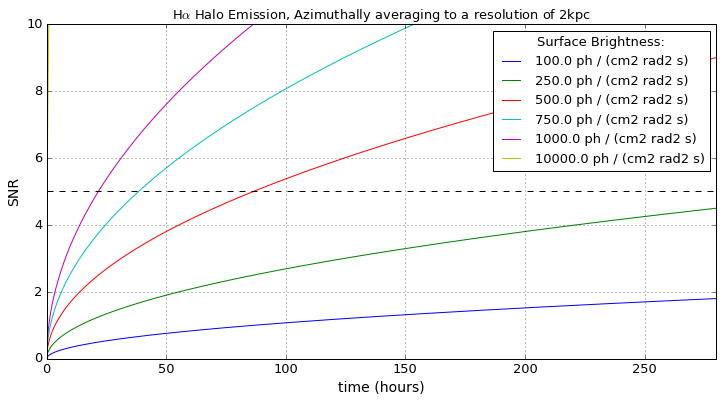

In [124]:
# pick numpixels:
numpixel = 800.*3.
label = 'Azimuthally averaging to a resolution of 2kpc'

# pick how long to calculate SNR over
time = np.arange(1,60.*60.*280.)* u.second
limit = time[-1]/u.second

fig,(ax1) = plt.subplots(1,1,figsize=(12, 6))

for SB_ph in [SB_ph_2, SB_ph_5,SB_ph_6,SB_ph_7, SB_ph_3, SB_ph_4]:
#for SB_ph in [SB_ph_upper, SB_ph_lower, SB_ph_evenlower, SB_ph_abslowest]:
    ## Signal
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    signal = S*time*numpixel
    ## Noise
    if old:
        B_tot = B * QE * tau_l * tau_f * 3.*u.nm * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    else:
        B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

    # Note that the signal is about an eighth the strength of the background sky signal: IS THIS TRUE HERE?
    print('Halpha Signal: '+str(S))
    print('Background Sky: ' +str(B_tot))

    ax1.plot(time/3600., signal/sigma, label=str(SB_ph))#,label= 'num pixels '+str(round(numpixel)))

ax1.plot([0,limit/3600.],[5,5],'k--')   
plt.title(r'H$\alpha$ Halo Emission, %s'%label)
ax1.legend(title='Surface Brightness:')
ax1.set_xlim(0,limit/3600.)
ax1.set_ylim(0,10)
ax1.set_xlabel('time (hours)')
ax1.set_ylabel('SNR')

#ax1.plot([10.,10.],[0,10],'k--')  # ~4 hour ~250min
#ax1.plot([100,100],[0,10],'k--')  # ~70 hour ~4200min
ax1.grid()

plt.savefig('SignalToNoise_azimuthalaveraging_standards.pdf')


Going from time and signal-to-noise to the original surface brightness:

In [191]:
# pick numpixels:
numpixel = 800.*3.

# pick how long to calculate SNR over
time = 100. * 60.* 60.* u.second
print SB_ph_2
S = SB_ph_2 * QE * tau_l * tau_f * area_lens * ang_size_pixel
signal = S*time*numpixel
print signal

B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
x = B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel

sigma = np.sqrt(signal + x)
signaltonoise = signal/sigma
print signaltonoise
signal_back = (signaltonoise**2 + np.sqrt(signaltonoise**4 + 4*signaltonoise**2*x))/2.
print signal_back

SB_ph_back = signal / (time*numpixel*QE * tau_l * tau_f * area_lens * ang_size_pixel)
print SB_ph_back

100.0 ph / (cm2 rad2 s)
73029.5933399 ph
1.07521146822 ph(1/2)
73029.5933399 ph
100.0 ph / (cm2 rad2 s)


Make two 2D arrays: one with signal-to-noise and one with time.  Then use these to make a map of the original surface brightness

In [174]:
time = np.arange(1,60.*60.*280.)* u.second
SNR = np.arange(0,10,0.01)

time = range(0,10)* u.second
SNR = range(0,10)
print SNR[::-1]
time2d = np.array([time for num in SNR])
print time2d
print time2d.shape

SNR2d = np.array([SNR[::-1] for num in time]).T/10.
print SNR2d
print SNR2d.shape

# make the output array one element shorter because will use the mean values of each of the other bins.
SB2d = np.zeros((SNR2d.shape[0]-1,SNR2d.shape[1]-1))
print SB2d
print SB2d.shape

print time2d[0,0]

for i in range(SB2d.shape[0]):
    for j in range(SB2d.shape[1]):
        thistime = np.mean([time2d[i,j],time2d[i+1,j+1]])
        thisSNR = np.mean([SNR2d[i,j],SNR2d[i+1,j+1]])
        SB2d[i,j] = thisSNR
        
print SB2d

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]]
(10, 10)
[[ 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9]
 [ 0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8]
 [ 0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7]
 [ 0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4]
 [ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]
 [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]

In [273]:
#time = np.arange(1,60.*60.*280.)* u.second
#SNR = np.arange(0,10,0.01)
time = range(1,140)#,280)
SNR = range(0,100)

time2d = np.array([time for num in SNR])
#SNR2d = np.array([SNR[::-1] for num in time]).T/10.
SNR2d = np.array([SNR for num in time]).T/10.

SB2d = np.zeros((SNR2d.shape[0]-1,SNR2d.shape[1]-1))

print time2d.shape,SNR2d.shape,SB2d.shape

(100, 139) (100, 139) (99, 138)


In [274]:
for i in range(SB2d.shape[0]):
    print i
    for j in range(SB2d.shape[1]):
        thistime = np.mean([time2d[i,j],time2d[i+1,j+1]]) * 60*60 * u.second * 2. # since want to go to 280 times 2
        thisSNR = np.mean([SNR2d[i,j],SNR2d[i+1,j+1]]) * u.photon**0.5

        B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
        x = B_tot*thistime*numpixel + D*thistime*numpixel + R_squared*numpixel

        signal_back = (thisSNR**2 + np.sqrt(thisSNR**4 + 4*thisSNR**2*x))/2.
        thisSB = signal_back / (thistime*numpixel*QE * tau_l * tau_f * area_lens * ang_size_pixel)
        #print thisSB.value
        SB2d[i,j] = thisSB.value

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


(99, 138)

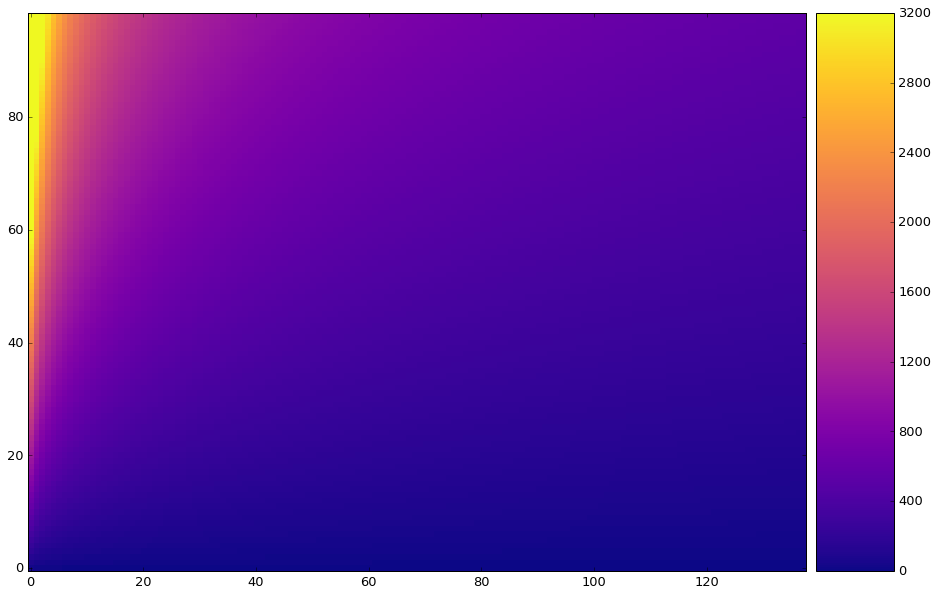

In [275]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(111)
plotdata(SB2d,ax=ax1,colorbar=True,colmap='plasma',bounds=[0,3200])#,extent=(0,280,0,10),aspect='equal')
SB2d.shape

In [288]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


['0', '2', '4', '6', '8']
['0', '40', '80', '120', '160', '200', '240']


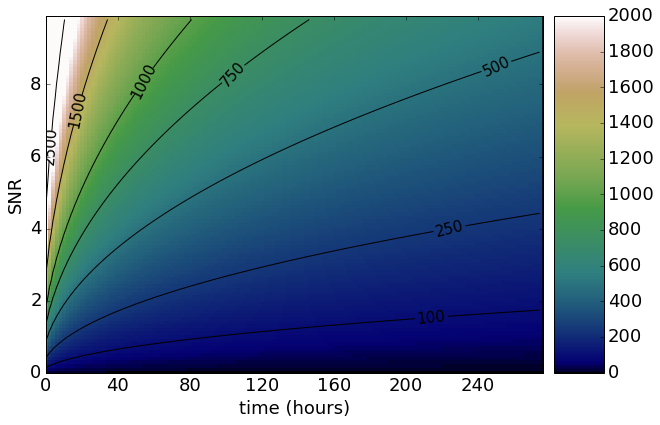

In [289]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
plotdata(SB2d,ax=ax1,colorbar=True,colmap='gist_earth',bounds=[0,2000])#,extent=[0,280,0,10])


## pick numpixels:
#numpixel = 800.*3.
#label = 'Azimuthally averaging to a resolution of 2kpc'
#
## pick how long to calculate SNR over
#time = np.arange(1,60.*60.*280.)* u.second
##limit = time[-1]/u.second
#
##fig,(ax1) = plt.subplots(1,1,figsize=(12, 6))#
#
#for SB_ph in [SB_ph_2, SB_ph_5,SB_ph_6,SB_ph_7, SB_ph_3]:#, SB_ph_4]:
##for SB_ph in [SB_ph_upper, SB_ph_lower, SB_ph_evenlower, SB_ph_abslowest]:
#    ## Signal
#    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
#    signal = S*time*numpixel
#    ## Noise
#    if old:
#        B_tot = B * QE * tau_l * tau_f * 3.*u.nm * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
#    else:
#        B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
#    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)
#
#    # Note that the signal is about an eighth the strength of the background sky signal: IS THIS TRUE HERE?
#    print('Halpha Signal: '+str(S))
#    print('Background Sky: ' +str(B_tot))
#
#    ax1.plot(time/3600., signal/sigma * 10, label=str(SB_ph))#,label= 'num pixels '+str(round(numpixel)))#
#
##ax1.plot([0,limit/3600.],[5,5],'k--')   
##plt.title(r'H$\alpha$ Halo Emission, %s'%label)
##ax1.legend(title='Surface Brightness:')
#ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=2, mode="expand", borderaxespad=0.)
ax1.set_xlim(0,278/2.-1)
ax1.set_ylim(0,99)

#ax1.set_yticks([0,20,40,60,80])
labels = [item.get_text() for item in ax1.get_yticklabels()]
labels = ['0','2','4','6','8']
print labels
ax1.set_yticklabels(labels)

labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['0','40','80','120','160','200','240']
print labels
ax1.set_xticklabels(labels)

ax1.set_xlabel('time (hours)')
ax1.set_ylabel('SNR')
#plt.tight_layout()
#ax1.plot([10.,10.],[0,10],'k--')  # ~4 hour ~250min
#ax1.plot([100,100],[0,10],'k--')  # ~70 hour ~4200min
#ax1.grid()

levels = [100,250,500,750,1000,1500,2500]
colours='k'
#cmap = cm.PRGn
CS = ax1.contour(SB2d,levels,colors=colours)#,cmap=cm.get_cmap(cmap, len(levels) - 1),)
ax1.clabel(CS, fontsize=15, inline=1, fmt='%.0f')

plt.savefig('SignalToNoise_azimuthalaveraging_map.pdf')


In [194]:
thistime = 150*60.*60.*u.second
thisSNR = 7.* u.photon**0.5

B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
x = B_tot*thistime*numpixel + D*thistime*numpixel + R_squared*numpixel

signal_back = (thisSNR**2 + np.sqrt(thisSNR**4 + 4*thisSNR**2*x))/2.
thisSB = signal_back / (thistime*numpixel*QE * tau_l * tau_f * area_lens * ang_size_pixel)
        #print thisSB.value
print thisSB

531.585599124 ph / (cm2 rad2 s)


In [197]:
print SB2d[0,0],time2d[0,0],SNR2d[0,0]

7484.79747725 1 9.9
